# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 

# magic word for producing visualizations in notebook
%matplotlib inline

#scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 0.1 Loading data

While loading in the data I got a warning: `DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False. interactivity=interactivity, compiler=compiler, result=result)`

In [4]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

attributes_values = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', header=1)
attribuets_desc = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx', header=1)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


I want to check the shape of the datasets and additional documents.

In [5]:
print('Azdias shape: ', azdias.shape)
print('Customers shape: ', customers.shape)
print('DIAS Attributes shape: ', attributes_values.shape)
print('DIAS Information Levels shape: ', attribuets_desc.shape)

Azdias shape:  (327460, 366)
Customers shape:  (191652, 369)
DIAS Attributes shape:  (2258, 5)
DIAS Information Levels shape:  (313, 5)


The description to the project mentioned that the "CUSTOMERS" file contains three extra columns. Thus, I want to check if this true.

In [6]:
print(customers.columns.symmetric_difference(azdias.columns))

Index(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype='object')


Earlier, I've got a warning, which means that some columns store in mixed-types. Therefore, before diving deeper into the analysis of the datasets, firstly,  I want to validate columns and fix the error. 
1. Checking data and source of warning

In [7]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


I want to know how does columns 18 and 19 look like and if there might be other columns with similar source of risk.

In [8]:
customers[customers.columns[customers.dtypes == 'object']]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1,13,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7,41,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER
...,...,...,...,...,...,...,...,...
191647,1C,1,14,D19_BANKEN_REST,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
191648,5B,5,32,D19_UNBEKANNT,1997-03-06 00:00:00,W,COSMETIC,SINGLE_BUYER
191649,4D,4,24,D19_TECHNIK,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
191650,4C,4,24,D19_BANKEN_REST,1992-02-10 00:00:00,W,FOOD,SINGLE_BUYER


In [9]:
customers['CAMEO_DEU_2015'].unique()

array(['1A', nan, '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B',
       '9D', '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D',
       '2A', '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E',
       '5E', '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F',
       '4D', 'XX'], dtype=object)

In [10]:
print('Customers (18, 19): - ', customers.iloc[:, 18:20].columns)
print('Azdias (18, 19): - ', azdias.iloc[:, 18:20].columns)
customers.groupby("CAMEO_DEUG_2015")["CAMEO_DEUG_2015"].count()

Customers (18, 19): -  Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')
Azdias (18, 19): -  Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


CAMEO_DEUG_2015
1.0     4280
2.0     5910
3.0     4805
4.0     5606
5.0     3042
6.0     4709
7.0     2680
8.0     3333
9.0     1661
1      12498
2      17574
3      13585
4      16458
5       8624
6      14008
7       7878
8       9716
9       4731
X        126
Name: CAMEO_DEUG_2015, dtype: int64

The problem of mixed types in columns is because there is actually a mix of float, int and string values. 
I assume that int anf float (e.g,: 12.0 and 12) represent the same criterea. Therefore, I will perform formating (float => int, X/XX => NaN)

In [11]:
customers.groupby("CAMEO_INTL_2015")["CAMEO_INTL_2015"].count()

CAMEO_INTL_2015
12.0      924
13.0     1955
14.0     4939
15.0     2372
22.0     1941
23.0     1494
24.0     4504
25.0     2472
31.0      681
32.0      440
33.0      396
34.0     1423
35.0      553
41.0     2859
43.0     2476
44.0      688
45.0     1352
51.0     2126
52.0      253
54.0     1258
55.0      920
12       2791
13       5728
14      14708
15       6845
22       5566
23       4276
24      13301
25       6900
31       2050
32       1256
33       1178
34       3945
35       1741
41       8461
43       7158
44       2144
45       3936
51       5987
52        770
54       3537
55       2794
XX        126
Name: CAMEO_INTL_2015, dtype: int64

Similar situatiation with AZDIAS dataframe.

In [12]:
azdias[azdias.columns[azdias.dtypes == 'object']]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
327455,5C,5,33,D19_UNBEKANNT,1992-02-10 00:00:00,O
327456,3D,3,25,NaN,1992-02-10 00:00:00,O
327457,6D,6,35,D19_BUCH_CD,1994-02-04 00:00:00,O
327458,8B,8,41,D19_UNBEKANNT,1992-02-10 00:00:00,O


In [13]:
def format_mixed_types(df):
    '''This function is created for formating improper 
    values in columns CAMEO_DEUG_2015 and CAMEO_INTL_2015'''
    
    cols_nan = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']
    cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    
    df[cols_nan] = df[cols_nan].replace({'X': np.nan, 'XX': np.nan})
    df[cols] = df[cols].astype(float)

    return df

In [14]:
customers = format_mixed_types(customers)

In [15]:
customers.groupby("CAMEO_DEUG_2015")["CAMEO_DEUG_2015"].count()

CAMEO_DEUG_2015
1.0    16778
2.0    23484
3.0    18390
4.0    22064
5.0    11666
6.0    18717
7.0    10558
8.0    13049
9.0     6392
Name: CAMEO_DEUG_2015, dtype: int64

Now we do not have a mixture of different data types, and values from float and int are properly merged. 

In [16]:
customers.groupby("CAMEO_INTL_2015")["CAMEO_INTL_2015"].count()

CAMEO_INTL_2015
12.0     3715
13.0     7683
14.0    19647
15.0     9217
22.0     7507
23.0     5770
24.0    17805
25.0     9372
31.0     2731
32.0     1696
33.0     1574
34.0     5368
35.0     2294
41.0    11320
43.0     9634
44.0     2832
45.0     5288
51.0     8113
52.0     1023
54.0     4795
55.0     3714
Name: CAMEO_INTL_2015, dtype: int64

In [17]:
customers['CAMEO_DEU_2015'].unique()

array(['1A', nan, '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B',
       '9D', '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D',
       '2A', '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E',
       '5E', '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F',
       '4D'], dtype=object)

In [18]:
azdias = format_mixed_types(azdias)

### 0.2 Checking attributes

After, we are finished with warning-problem, I would like to have a quick look on the attributes files.

In [19]:
attribuets_desc.drop(columns=['Unnamed: 0'], inplace=True)
attributes_values.drop(columns=['Unnamed: 0'], inplace=True)

In [20]:
attribuets_desc.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [21]:
attributes_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


From the observations I may conclude that those dataframes contain descriptions for each column name in AZDIAS and CUSTOMERS files as well as the range of the proper values.

In [22]:
attributes_values['Attribute'] = attributes_values['Attribute'].ffill()
attributes_values['Description'] = attributes_values['Description'].ffill()
attributes_values

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
...,...,...,...,...
2253,ZABEOTYP,typification of energy consumers,2,smart
2254,ZABEOTYP,typification of energy consumers,3,fair supplied
2255,ZABEOTYP,typification of energy consumers,4,price driven
2256,ZABEOTYP,typification of energy consumers,5,seeking orientation


At this point, I want to check what is common for all given datafiles.

In [23]:
customers_unique = set(list(customers.columns))
azdias_unique = set(list(azdias.columns))
attribuets_desc_unique = set(list(attribuets_desc.Attribute))
attributes_values_unique = set(list(attributes_values.Attribute))

print('No of columns in CUSTOMESRS: ', len(customers_unique))
print('No of columns in AZDIAS: ', len(azdias_unique))
print('No of columns in Attributes description: ', len(attribuets_desc_unique))
print('No of columns in Attributes values: ', len(attributes_values_unique))

common = customers_unique & azdias_unique & attribuets_desc_unique
print('No of columns in common: ', len(common))

No of columns in CUSTOMESRS:  369
No of columns in AZDIAS:  366
No of columns in Attributes description:  313
No of columns in Attributes values:  314
No of columns in common:  264


### 0.3  Missing values

While observing the Attributes values, CUSTOMERS and AZDIAS dataframes I have mentioned that by now there are 3 types of the missing data:
1. NaN that are already present in the dataframe
2. X and XX values in columns 18 and 19, that we have already handeled
3. In the `DIAS Attributes - Values 2017.xlsx` file in the column `Value` there are corresponding encoding for the `unknown` values

Therefore, I want to know all encoding for the unknown vlues of ecah column of dataset. For this purpose I have created the dictionary, where key is name of the column and the value is an unknown encoding. After, I retrieved all necessary information,I can perform missing value replacement (for each entry in dictionary I will check dataframe where column equals key and if such column contains values such as value of the dictionary under current key I will replace this value of the dataframe with numpy.nan.

In [24]:
'''This dictionary stores the encoding values of the unknowns for each column of the dataset'''
dict_of_unknown_names = {}
for i, row in attributes_values.iterrows():
    if "unknown" in str(row['Meaning']):
        dict_of_unknown_names[row['Attribute']] = [int(num) for num in str(row['Value']).split(', ')]
print(dict_of_unknown_names)

{'AGER_TYP': [-1], 'ALTERSKATEGORIE_GROB': [-1, 0], 'ALTER_HH': [0], 'ANREDE_KZ': [-1, 0], 'BALLRAUM': [-1], 'BIP_FLAG': [-1], 'CAMEO_DEUG_2015': [-1], 'CAMEO_DEUINTL_2015': [-1], 'CJT_GESAMTTYP': [0], 'D19_KK_KUNDENTYP': [-1], 'EWDICHTE': [-1], 'FINANZTYP': [-1], 'FINANZ_ANLEGER': [-1], 'FINANZ_HAUSBAUER': [-1], 'FINANZ_MINIMALIST': [-1], 'FINANZ_SPARER': [-1], 'FINANZ_UNAUFFAELLIGER': [-1], 'FINANZ_VORSORGER': [-1], 'GEBAEUDETYP': [-1, 0], 'GEOSCORE_KLS7': [-1, 0], 'HAUSHALTSSTRUKTUR': [-1, 0], 'HEALTH_TYP': [-1], 'HH_EINKOMMEN_SCORE': [-1, 0], 'INNENSTADT': [-1], 'KBA05_ALTER1': [-1, 9], 'KBA05_ALTER2': [-1, 9], 'KBA05_ALTER3': [-1, 9], 'KBA05_ALTER4': [-1, 9], 'KBA05_ANHANG': [-1, 9], 'KBA05_ANTG1': [-1], 'KBA05_ANTG2': [-1], 'KBA05_ANTG3': [-1], 'KBA05_ANTG4': [-1], 'KBA05_AUTOQUOT': [-1, 9], 'KBA05_BAUMAX': [-1, 0], 'KBA05_CCM1': [-1, 9], 'KBA05_CCM2': [-1, 9], 'KBA05_CCM3': [-1, 9], 'KBA05_CCM4': [-1, 9], 'KBA05_DIESEL': [-1, 9], 'KBA05_FRAU': [-1, 9], 'KBA05_GBZ': [-1, 0], 'KBA

In [25]:
def replace_unknown_with_nan(df, dictionary):
    '''This function accept a dataframe which is 
    going to be check for the missing values accorfing 
    to the dictionary and if such exists it will be replaced with numpy.nan.'''
    for key, value in dictionary.items():
        #print(key, value)
        if key in df.columns:
            for i in range(0, len(value)):
                df.loc[df[key] == value[i], key] = np.nan

filtered_customers = customers.copy()
filtered_azdias = azdias.copy()
replace_unknown_with_nan(filtered_customers, dict_of_unknown_names)
replace_unknown_with_nan(filtered_azdias, dict_of_unknown_names)


Now, we will have a look on quantity of NaN values before and after the implementation of the replace_unknown_with_nan().

In [26]:
print('Pre-filtered Cusmomer df, no of NaN values: ',customers.isna().sum().sum())
print('Post-filtered Cusmomer df, no of actual NaN values: ', filtered_customers.isna().sum().sum())

print('Pre-filtered Azdias df, no of NaN values: ', azdias.isna().sum().sum())
print('Post-filtered Azdias df, no of actual NaN values: ', filtered_azdias.isna().sum().sum())
#filtered_customers.head()

Pre-filtered Cusmomer df, no of NaN values:  13864900
Post-filtered Cusmomer df, no of actual NaN values:  14488847
Pre-filtered Azdias df, no of NaN values:  12239101
Post-filtered Azdias df, no of actual NaN values:  13557716


In [27]:
adzias = None
customers = None

In [28]:
def get_unique_values(df):
    dict_unique_values = {}
    for col in df.columns:
        if col != "LNR":
            dict_unique_values[col] = df[col].unique()
            #print(f'{col} unique vals: {df[col].unique()}')
    return dict_unique_values

In [29]:
def get_attributes_range():
    dict_of_attr = {}
    for i, row in attributes_values.iterrows():
        #print(row['Attribute'])
        if row['Attribute'] in dict_of_attr:
            dict_of_attr[row['Attribute']].append(row['Value'])
        else:
            dict_of_attr[row['Attribute']] = [row['Value']]
    #print(dict_of_attr)
    return dict_of_attr

In [30]:
print(get_unique_values(filtered_azdias))

{'AGER_TYP': array([nan,  2.,  3.,  0.,  1.]), 'AKT_DAT_KL': array([nan,  9.,  1.,  5.,  8.,  7.,  6.,  4.,  3.,  2.]), 'ALTER_HH': array([nan, 17., 13., 20., 10., 14., 16., 21., 11., 19., 15.,  9., 18.,
        8.,  7., 12.,  4.,  3.,  6.,  5.,  2.,  1.]), 'ALTER_KIND1': array([nan, 17., 10., 18., 13., 16., 11.,  6.,  8.,  9., 15., 14.,  7.,
       12.,  4.,  3.,  5.,  2.]), 'ALTER_KIND2': array([nan, 13.,  8., 12., 10.,  7., 16., 15., 14., 17.,  5.,  9., 18.,
       11.,  6.,  4.,  3.,  2.]), 'ALTER_KIND3': array([nan, 10., 18., 17., 16.,  8., 15.,  9., 12., 13., 14., 11.,  7.,
        5.,  6.]), 'ALTER_KIND4': array([nan, 10.,  9., 16., 14., 13., 11., 18., 17., 15.,  8., 12.]), 'ALTERSKATEGORIE_FEIN': array([nan, 21., 17., 13., 14., 10., 16., 20., 11., 19., 15., 18.,  9.,
       22., 12.,  0.,  8.,  7., 23.,  4., 24.,  6.,  3.,  2.,  5., 25.,
        1.]), 'ANZ_HAUSHALTE_AKTIV': array([ nan,  11.,  10.,   1.,   3.,   5.,   4.,   6.,   2.,   9.,   0.,
        14.,  13.,   8.,   7.,  

In [31]:
attributes_proper_range = get_attributes_range()
print(attributes_proper_range)

{'AGER_TYP': [-1, 0, 1, 2, 3], 'ALTERSKATEGORIE_GROB': ['-1, 0', 1, 2, 3, 4, 9], 'ALTER_HH': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], 'ANREDE_KZ': ['-1, 0', 1, 2], 'ANZ_HAUSHALTE_AKTIV': ['…'], 'ANZ_HH_TITEL': ['…'], 'ANZ_PERSONEN': ['…'], 'ANZ_TITEL': ['…'], 'BALLRAUM': [-1, 1, 2, 3, 4, 5, 6, 7], 'BIP_FLAG': [-1, 0, 1], 'CAMEO_DEUG_2015': [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'CAMEO_DEU_2015': ['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B', '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D', '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E'], 'CAMEO_DEUINTL_2015': [-1, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 41, 42, 43, 44, 45, 51, 52, 53, 54, 55], 'CJT_GESAMTTYP': [0, 1, 2, 3, 4, 5, 6], 'D19_BANKEN_ANZ_12': [0, 1, 2, 3, 4, 5, 6], 'D19_BANKEN_ANZ_24': [0, 1, 2, 3, 4, 5, 6], 'D19_BANKEN_DATUM': [1, 2, 3, 4, 5, 6, 7, 8, 9

In [32]:
for key, value in attributes_proper_range.items():
    print(f'{key}, => {len(value)}')

AGER_TYP, => 5
ALTERSKATEGORIE_GROB, => 6
ALTER_HH, => 22
ANREDE_KZ, => 3
ANZ_HAUSHALTE_AKTIV, => 1
ANZ_HH_TITEL, => 1
ANZ_PERSONEN, => 1
ANZ_TITEL, => 1
BALLRAUM, => 8
BIP_FLAG, => 3
CAMEO_DEUG_2015, => 10
CAMEO_DEU_2015, => 44
CAMEO_DEUINTL_2015, => 26
CJT_GESAMTTYP, => 7
D19_BANKEN_ANZ_12, => 7
D19_BANKEN_ANZ_24, => 7
D19_BANKEN_DATUM, => 10
D19_BANKEN_DIREKT_RZ, => 8
D19_BANKEN_GROSS_RZ, => 8
D19_BANKEN_LOKAL_RZ, => 8
D19_BANKEN_OFFLINE_DATUM, => 10
D19_BANKEN_ONLINE_DATUM, => 10
D19_BANKEN_ONLINE_QUOTE_12, => 11
D19_BANKEN_REST_RZ, => 8
D19_BEKLEIDUNG_GEH_RZ, => 8
D19_BEKLEIDUNG_REST_RZ, => 8
D19_BILDUNG_RZ, => 8
D19_BIO_OEKO_RZ, => 8
D19_BUCH_RZ, => 8
D19_DIGIT_SERV_RZ, => 8
D19_DROGERIEARTIKEL_RZ, => 8
D19_ENERGIE_RZ, => 8
D19_FREIZEIT_RZ, => 8
D19_GARTEN_RZ, => 8
D19_GESAMT_ANZ_12, => 7
D19_GESAMT_ANZ_24, => 7
D19_GESAMT_DATUM, => 10
D19_GESAMT_OFFLINE_DATUM, => 10
D19_GESAMT_ONLINE_DATUM, => 10
D19_GESAMT_ONLINE_QUOTE_12, => 11
D19_HANDWERK_RZ, => 8
D19_HAUS_DEKO_RZ, => 8
D19_

In [33]:
def get_difference(actual_entries_dictionary):
    
    dict_of_outliers = {}
    for key, value in actual_entries_dictionary.items():
        if key in attributes_proper_range:
            dict_of_outliers[key] = [item for item in value if item not in attributes_proper_range[key]]
    return dict_of_outliers

In [34]:
validation_dict = get_difference(get_unique_values(filtered_azdias))
for key, value in validation_dict.items():
    if len(value) > 1 or (len(value) == 1 and "nan" not in str(value[0])):
        print(key, value)

ANZ_HAUSHALTE_AKTIV [nan, 11.0, 10.0, 1.0, 3.0, 5.0, 4.0, 6.0, 2.0, 9.0, 0.0, 14.0, 13.0, 8.0, 7.0, 44.0, 25.0, 36.0, 16.0, 272.0, 33.0, 15.0, 12.0, 22.0, 21.0, 20.0, 67.0, 23.0, 18.0, 27.0, 24.0, 31.0, 39.0, 19.0, 30.0, 17.0, 29.0, 61.0, 54.0, 88.0, 49.0, 60.0, 38.0, 34.0, 48.0, 35.0, 62.0, 26.0, 45.0, 42.0, 28.0, 77.0, 47.0, 50.0, 236.0, 137.0, 43.0, 52.0, 41.0, 76.0, 63.0, 32.0, 40.0, 37.0, 59.0, 53.0, 57.0, 118.0, 66.0, 95.0, 78.0, 70.0, 46.0, 185.0, 73.0, 154.0, 80.0, 102.0, 92.0, 126.0, 94.0, 71.0, 68.0, 81.0, 69.0, 121.0, 258.0, 58.0, 86.0, 124.0, 85.0, 90.0, 128.0, 51.0, 72.0, 64.0, 56.0, 83.0, 150.0, 259.0, 91.0, 160.0, 134.0, 169.0, 246.0, 82.0, 114.0, 183.0, 116.0, 74.0, 143.0, 99.0, 216.0, 98.0, 125.0, 112.0, 123.0, 55.0, 120.0, 75.0, 141.0, 103.0, 87.0, 89.0, 223.0, 93.0, 179.0, 135.0, 149.0, 97.0, 101.0, 110.0, 79.0, 111.0, 109.0, 65.0, 84.0, 367.0, 162.0, 195.0, 107.0, 119.0, 331.0, 122.0, 161.0, 157.0, 175.0, 177.0, 136.0, 104.0, 316.0, 127.0, 100.0, 180.0, 155.0, 133.0

In [35]:
additional_missing_values = {'KBA05_MODTEMP': [6.0], 'LP_FAMILIE_FEIN': [0.0], 'LP_FAMILIE_GROB': [0.0],
                            'LP_LEBENSPHASE_FEIN': [0.0], 'LP_LEBENSPHASE_GROB': [0.0], 'ORTSGR_KLS9': [0.0], 'GEBURTSJAHR': [0]}

replace_unknown_with_nan(filtered_customers, additional_missing_values)
replace_unknown_with_nan(filtered_azdias, additional_missing_values)

Now, it is time to check the quantity of the missing values in each column. I would like to know how much it is in percents as well.

In [36]:
def extract_missing_data_cols(df):
    '''This function accepts the dataframe, extracts 
    the columns with missing data and calculates 
    the percentage of the NaN values for each column.'''
    md_cols = pd.Series(df.isna().sum()[df.isna().sum()>0], name="num").to_frame()
    md_cols = md_cols.assign(perc_of_miss=lambda x: round((x.num*100 / df.shape[0]),2))
    md_cols = md_cols.sort_values('perc_of_miss', ascending=False)
    return md_cols

In [37]:
customers_missing_data_df = extract_missing_data_cols(filtered_customers)
customers_missing_data_df

,num,perc_of_miss
ALTER_KIND4,191416,99.88
ALTER_KIND3,190377,99.33
TITEL_KZ,189340,98.79
ALTER_KIND2,186552,97.34
ALTER_KIND1,179886,93.86
...,...,...
CJT_TYP_2,3213,1.68
RETOURTYP_BK_S,3213,1.68
RT_KEIN_ANREIZ,3213,1.68
CJT_TYP_3,3213,1.68


From the table above we can see that there are some columns in dataset that have extremely high percentage of the missing data. They are basically empty. I also wanted to check them in the form of diagram.

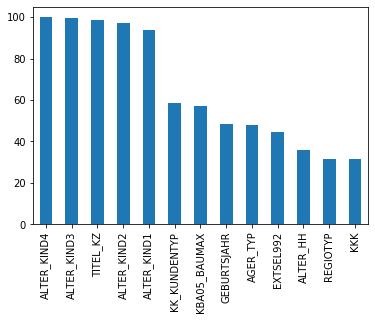

In [38]:
customers_missing_data_df[customers_missing_data_df.perc_of_miss > 30].perc_of_miss.plot(kind='bar');
plt.show()

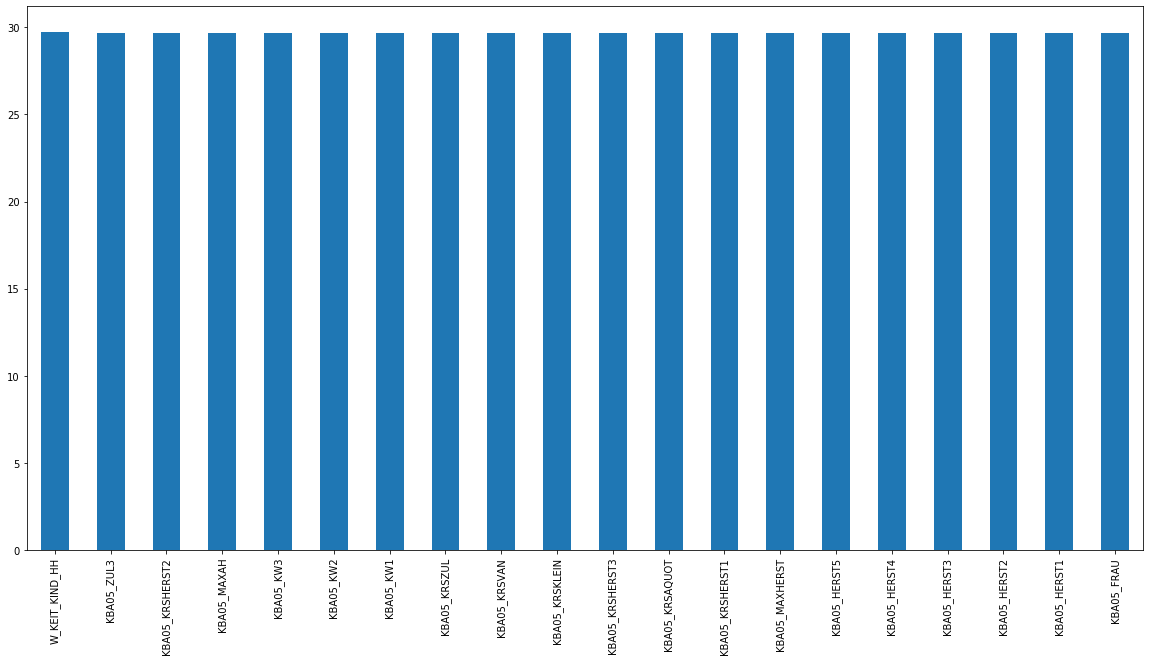

In [39]:
customers_missing_data_df[customers_missing_data_df.perc_of_miss < 30].perc_of_miss[:20].plot(figsize = (20, 10), kind = 'bar');
plt.show()

Simmilar with CUSTOOMERS dataframe.

In [40]:
azdias_missing_data_df = extract_missing_data_cols(filtered_azdias)
azdias_missing_data_df

,num,perc_of_miss
ALTER_KIND4,327003,99.86
TITEL_KZ,326675,99.76
ALTER_KIND3,325144,99.29
ALTER_KIND2,316481,96.65
ALTER_KIND1,297458,90.84
...,...,...
SEMIO_MAT,1,0.00
SEMIO_LUST,1,0.00
SEMIO_KULT,1,0.00
SEMIO_KRIT,1,0.00


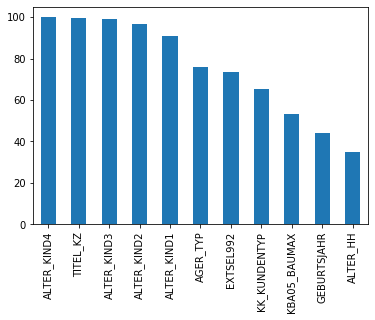

In [41]:
azdias_missing_data_df[azdias_missing_data_df.perc_of_miss > 30].perc_of_miss.plot(kind='bar');
plt.show()

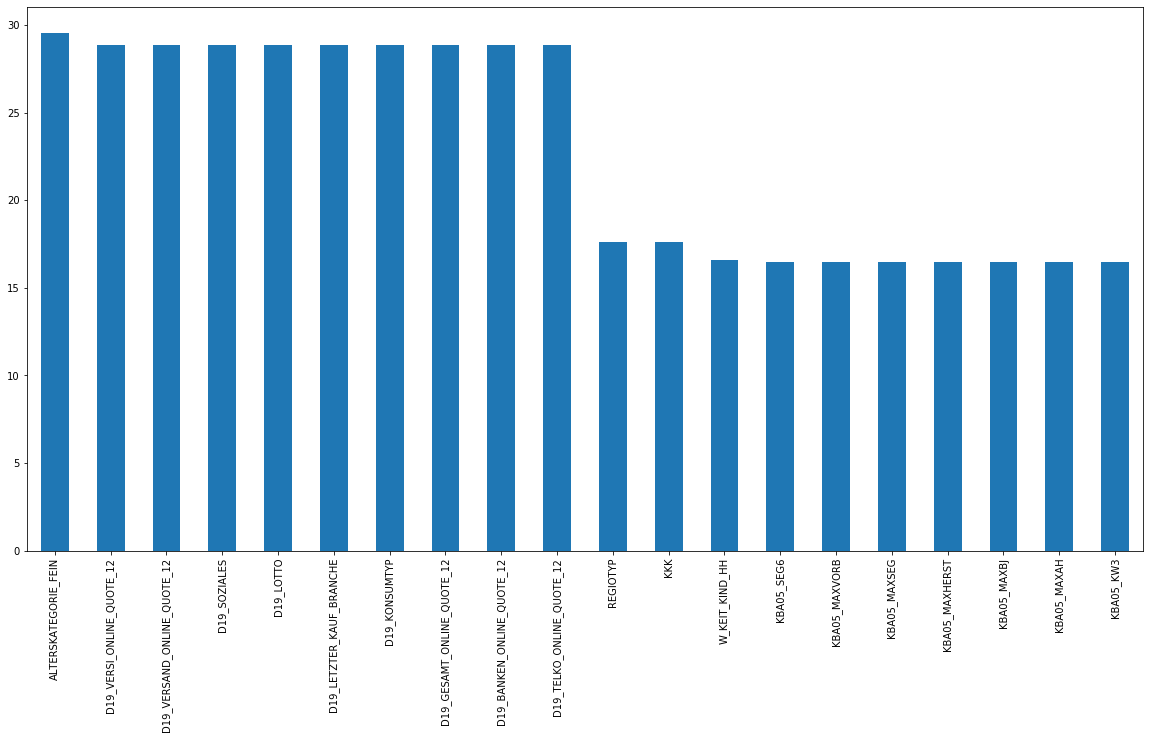

In [42]:
azdias_missing_data_df[azdias_missing_data_df.perc_of_miss < 30].perc_of_miss[:20].plot(figsize = (20, 10), kind = 'bar');
plt.show()

Now I want to compare the missing data from AZDIAS with CUSTOMERS. Therefore, I will merge them by column name.

In [43]:
merged = azdias_missing_data_df.reset_index()
merged.rename(columns={'perc_of_miss':'azdias_miss'}, inplace=True)
del merged["num"]
merged

,index,azdias_miss
0,ALTER_KIND4,99.86
1,TITEL_KZ,99.76
2,ALTER_KIND3,99.29
3,ALTER_KIND2,96.65
4,ALTER_KIND1,90.84
...,...,...
293,SEMIO_MAT,0.00
294,SEMIO_LUST,0.00
295,SEMIO_KULT,0.00
296,SEMIO_KRIT,0.00


In [44]:
temp_cus = customers_missing_data_df.reset_index()
temp_cus.rename(columns={'perc_of_miss':'cust_miss'}, inplace=True)
del temp_cus["num"]
temp_cus


,index,cust_miss
0,ALTER_KIND4,99.88
1,ALTER_KIND3,99.33
2,TITEL_KZ,98.79
3,ALTER_KIND2,97.34
4,ALTER_KIND1,93.86
...,...,...
275,CJT_TYP_2,1.68
276,RETOURTYP_BK_S,1.68
277,RT_KEIN_ANREIZ,1.68
278,CJT_TYP_3,1.68


In [45]:
merged = merged.merge(temp_cus, on='index')
merged

,index,azdias_miss,cust_miss
0,ALTER_KIND4,99.86,99.88
1,TITEL_KZ,99.76,98.79
2,ALTER_KIND3,99.29,99.33
3,ALTER_KIND2,96.65,97.34
4,ALTER_KIND1,90.84,93.86
...,...,...,...
275,CJT_GESAMTTYP,0.56,1.68
276,CJT_TYP_5,0.56,1.68
277,CJT_TYP_6,0.56,1.68
278,GFK_URLAUBERTYP,0.56,1.68


After I have substratedd all the required data and merged it, I would like to represent it in the form of bar-plot for better understanding.

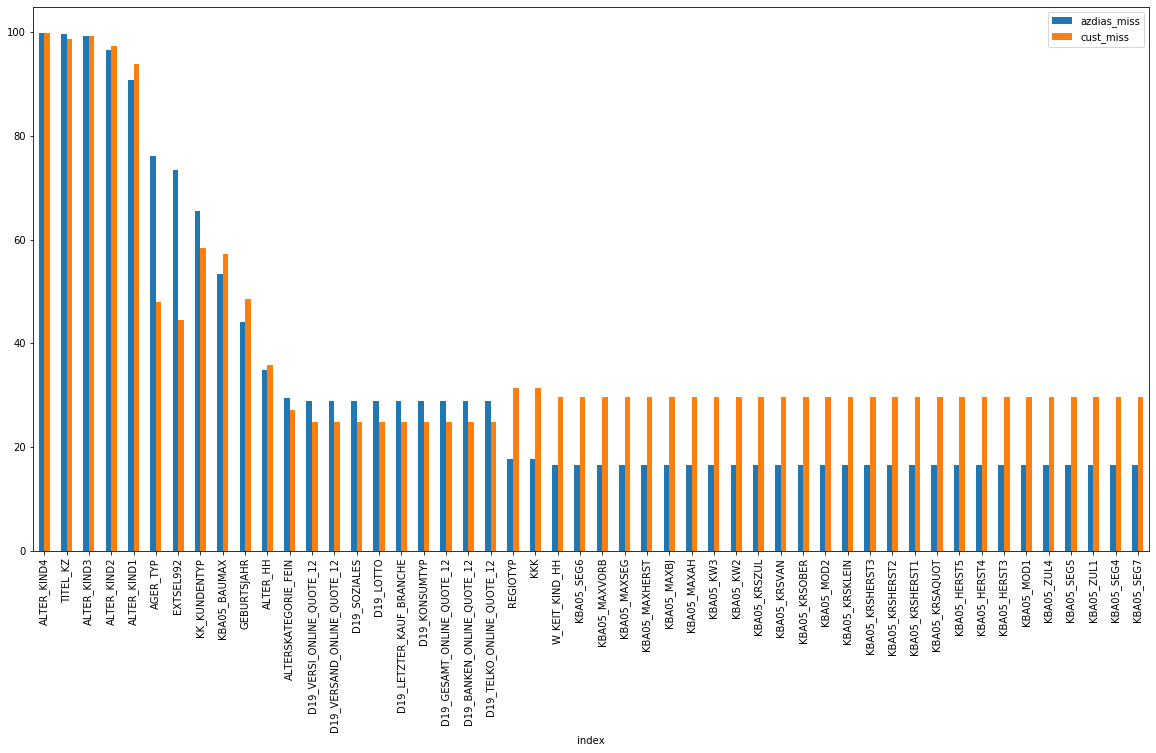

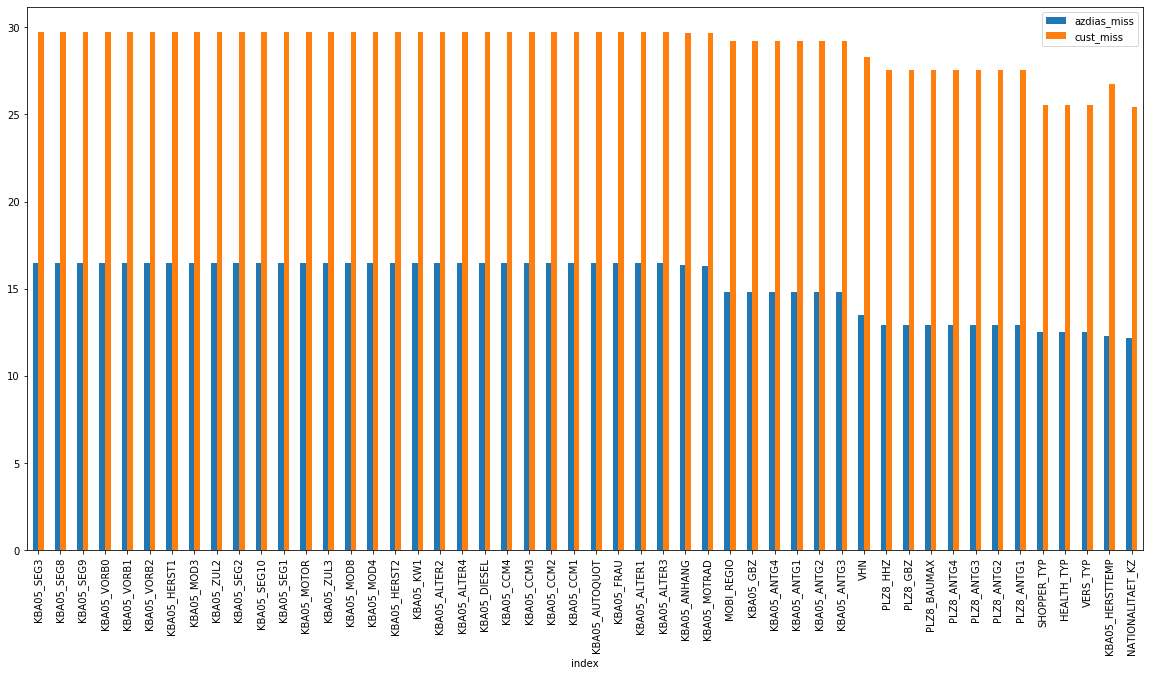

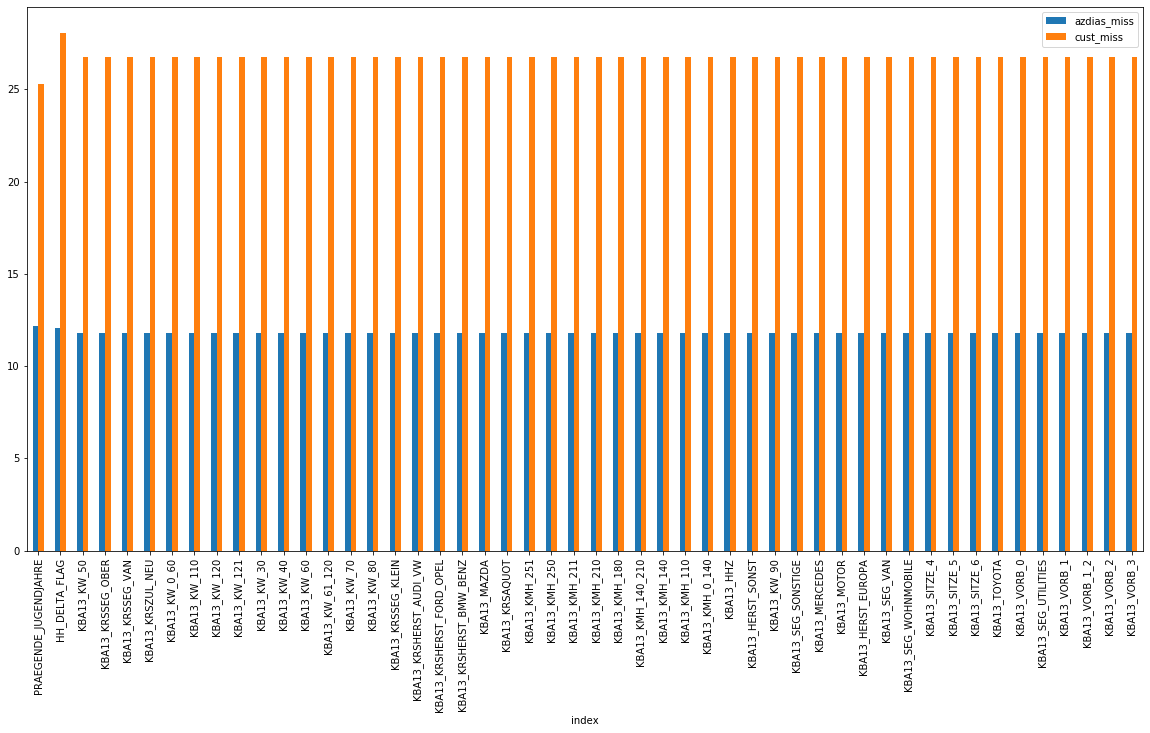

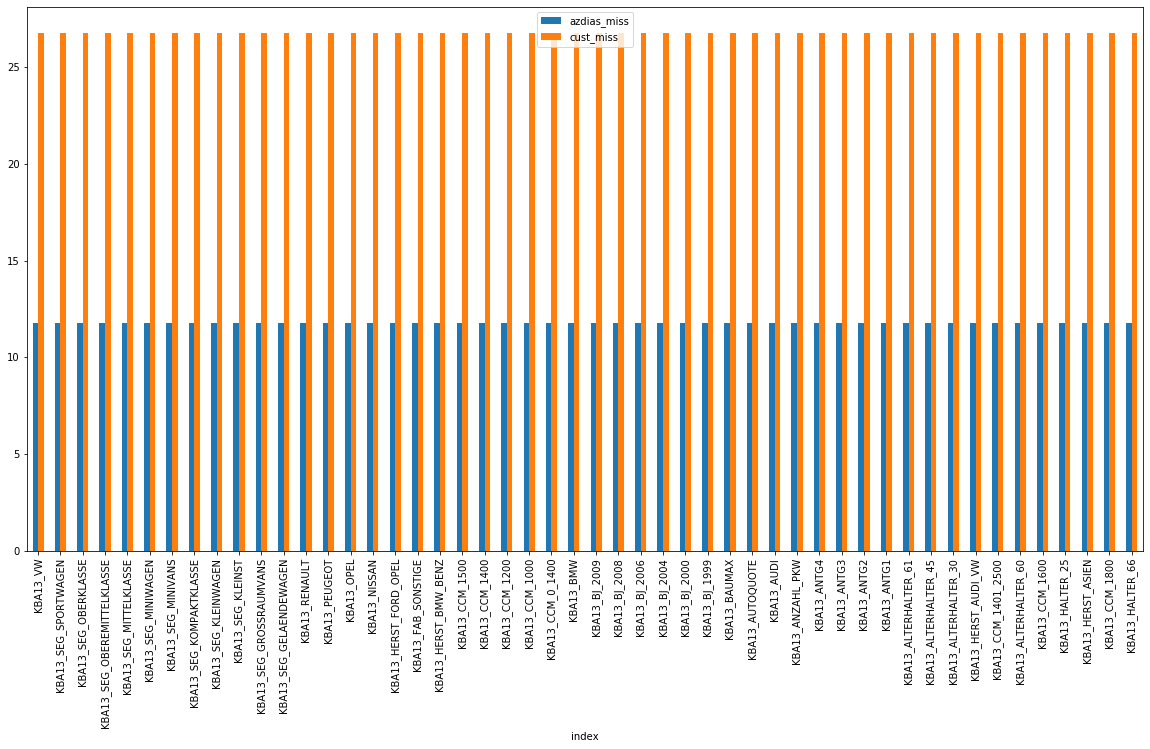

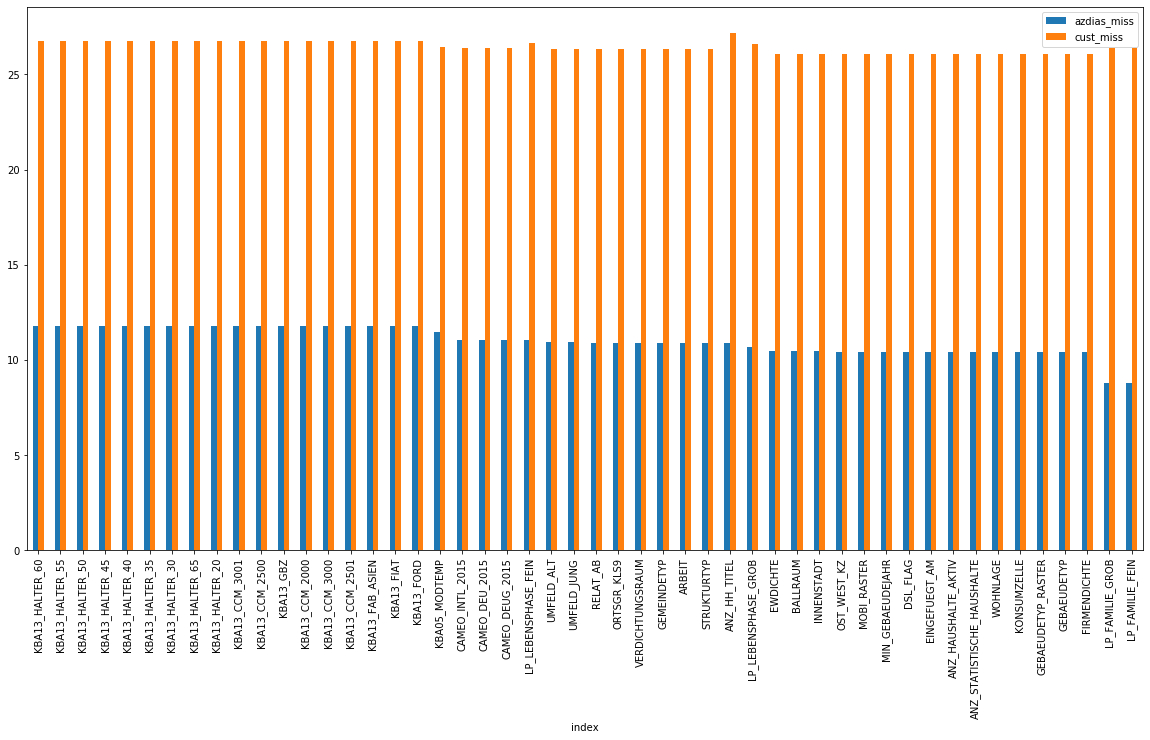

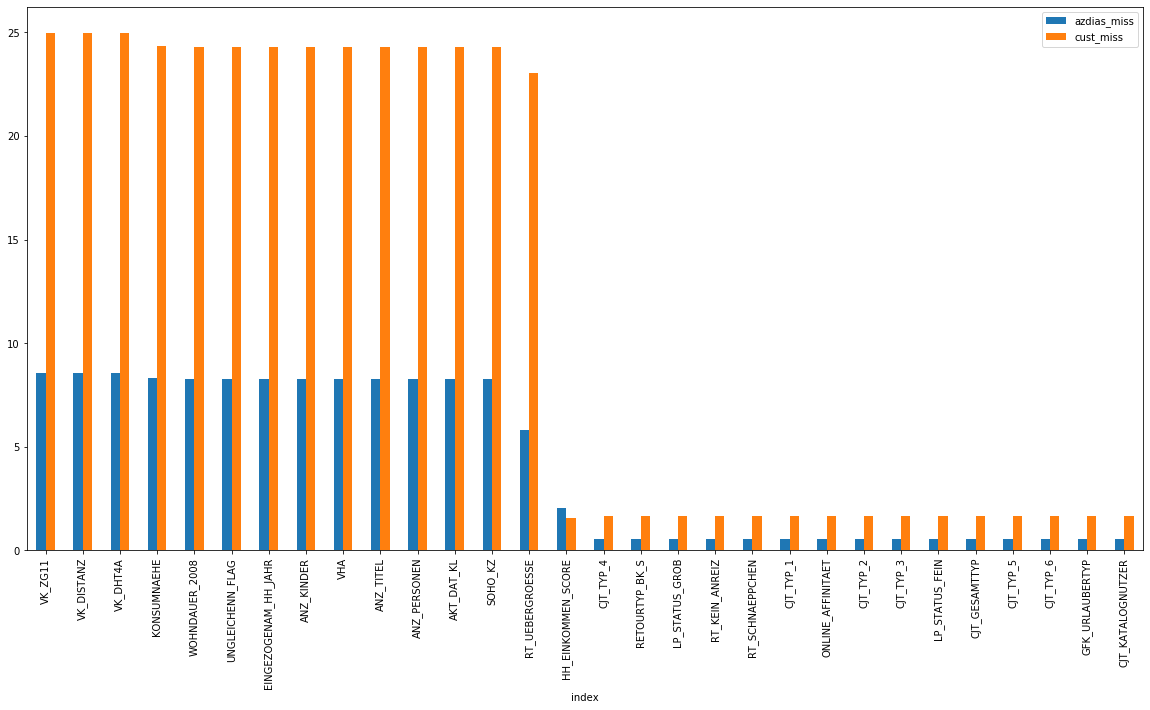

In [46]:
for i in range(0, len(merged), 50):
    
    merged[i:i+50].plot(x ='index', figsize=(20,10), kind = 'bar')

Based on the abovedepicted graph, I have made a decision to drop completely such columns where percentage of missing values in AZDIAS and CUSTOMERS bigger than 30%. 

In [47]:
merged_unique = set(list(merged['index']))
#print(len(attribuets_desc_unique & merged_unique))

In [48]:
cols_to_drop = list(merged.loc[(merged['azdias_miss'] > 30) & (merged['cust_miss'] > 30)]['index'])
cols_to_drop

['ALTER_KIND4',
 'TITEL_KZ',
 'ALTER_KIND3',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'AGER_TYP',
 'EXTSEL992',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [49]:
azdias_missing_data_df = None
customers_missing_data_df = None
merged = None

In [50]:
filtered_azdias = filtered_azdias.drop(cols_to_drop, axis = 1)
filtered_customers = filtered_customers.drop(cols_to_drop, axis = 1)

In [51]:
print(filtered_azdias.shape)
print(filtered_customers.shape)

(327460, 355)
(191652, 358)


In [52]:
cols_to_drop = list((set(filtered_azdias.columns) & set(filtered_customers.columns)).difference(attribuets_desc_unique))

In [53]:
filtered_azdias = filtered_azdias.drop(cols_to_drop, axis = 1)
filtered_customers = filtered_customers.drop(cols_to_drop, axis = 1)

In [54]:
print('Post-filtered Azdias df, no of left NaN values: ', filtered_azdias.isna().sum().sum())
print('Post-filtered Customers df, no of left NaN values: ', filtered_customers.isna().sum().sum())

Post-filtered Azdias df, no of left NaN values:  9317009
Post-filtered Customers df, no of left NaN values:  11213580


In [55]:
def feature_eng(df):
    
    labelencoder = LabelEncoder()

    
    df['ANZ_HAUSHALTE_AKTIV'].fillna(df['ANZ_HAUSHALTE_AKTIV'].mean(), inplace=True)
    print('Replaced ANZ_HAUSHALTE_AKTIV')
    df['KBA13_ANZAHL_PKW'].fillna(df['KBA13_ANZAHL_PKW'].mean(), inplace=True)
    print('Replaced KBA13_ANZAHL_PKW')
    
    #CAMEO_INTL_2015
    cameo_wealth_type = {
        11:'Wealthy', 12:'Wealthy',13:'Wealthy', 14:'Wealthy', 15:'Wealthy', 
        21:'Prosperous', 22:'Prosperous', 23:'Prosperous', 24:'Prosperous', 25:'Prosperous',
        31:'Comfortable', 32:'Comfortable', 33:'Comfortable', 34:'Comfortable', 35:'Comfortable',
        41:'Less Affluent', 42:'Less Affluent', 43:'Less Affluent', 44:'Less Affluent', 45:'Less Affluent',
        51:'Poorer', 52:'Poorer', 53:'Poorer', 54:'Poorer', 55:'Poorer'
    }
    cameo_family_type = {
        11:'Pre-Family Couples & Singles',
        12:'Young Couples With Children',
        13:'Families With School Age Children',
        14:'Older Families &  Mature Couples',
        15:'Elders In Retirement',
        21:'Pre-Family Couples & Singles',
        22:'Young Couples With Children',
        23:'Families With School Age Children',
        24:'Older Families &  Mature Couples',
        25:'Elders In Retirement',
        31:'Pre-Family Couples & Singles',
        32:'Young Couples With Children',
        33:'Families With School Age Children',
        34:'Older Families &  Mature Couples',
        35:'Elders In Retirement',
        41:'Pre-Family Couples & Singles',
        42:'Young Couples With Children',
        43:'Families With School Age Children',
        44:'Older Families &  Mature Couples',
        45:'Elders In Retirement',
        51:'Pre-Family Couples & Singles',
        52:'Young Couples With Children',
        53:'Families With School Age Children',
        54:'Older Families &  Mature Couples',
        55:'Elders In Retirement',

    }
    
    #not in customers, but in azdias
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_wealth_type'] = df['CAMEO_INTL_2015'].map(cameo_wealth_type)
        df['CAMEO_INTL_2015_family_type'] = df['CAMEO_INTL_2015'].map(cameo_family_type)
    
    #LP_LEBENSPHASE_FEIN
    family_type_dict = {
        1: 'single', 2: 'single', 3: 'single', 4: 'single', 5: 'single', 6: 'single', 7: 'single',
        8: 'single', 9: 'single', 10:'single', 11:'single', 12:'single', 13:'single', 14:'couples',
        15:'couples', 16:'couples', 17:'couples', 18:'couples', 19:'couples', 20:'couples', 21:'single_parent',
        22:'single_parent', 23:'single_parent', 24:'families', 25:'families', 26:'families', 27:'families', 28:'families',
        29:'mulitperson_households', 30:'mulitperson_households', 31:'mulitperson_households', 32:'mulitperson_households',
        33:'mulitperson_households', 34:'mulitperson_households', 35:'mulitperson_households', 36:'mulitperson_households',
        37:'mulitperson_households', 38:'mulitperson_households', 39:'mulitperson_households', 40:'mulitperson_households'
    }
    earner_type_dict = {
        1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low', 7: 'average',
        8: 'average', 9: 'independant', 10:'wealthy', 11:'homeowners', 12:'homeowners', 13:'top', 14:'low',
        15: 'low', 16:'average', 17: 'independant', 18:'wealthy', 19:'homeowners', 20:'top', 21:'low',
        22: 'average', 23:'high', 24:'low', 25:'average', 26: 'independant', 27:'homeowners', 28:'top',
        29: 'low', 30:'average', 31:'low', 32:'average',
        33: 'independant', 34:'homeowners', 35:'top', 36: 'independant',
        37: 'homeowners', 38:'homeowners', 39:'top', 40:'top'
    }
    age_group_dict = {
        1: 'younger_age', 2: 'middle_age', 3: 'younger_age', 4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age', 7: 'advanced_age',
        8: 'retirement_age', 9: np.nan, 10: np.nan, 11:'advanced_age', 12:'retirement_age', 13:'higher_age', 14:'younger_age',
        15: 'higher_age', 16:'higher_age', 17: np.nan, 18:'younger_age', 19:'higher_age', 20:'higher_age', 21: np.nan,
        22: np.nan, 23:np.nan, 24:np.nan, 25:np.nan, 26: np.nan, 27:np.nan, 28:np.nan,
        29: 'younger_age', 30:'younger_age', 31:'higher_age', 32:'higher_age',
        33: 'younger_age', 34:'younger_age', 35:'younger_age', 36: 'higher_age',
        37: 'advanced_age', 38:'retirement_age', 39:'middle_age', 40:'retirement_age'
    }
    
    df['LP_LEBENSPHASE_FEIN_family_type'] = df['LP_LEBENSPHASE_FEIN'].map(family_type_dict)
    df['LP_LEBENSPHASE_FEIN_earner_type'] = df['LP_LEBENSPHASE_FEIN'].map(earner_type_dict)
    df['LP_LEBENSPHASE_FEIN_age_group'] = df['LP_LEBENSPHASE_FEIN'].map(age_group_dict)
    
    #LP_FAMILIE_GROB
    family_type_dict = {
        1: 'single', 2: 'couple', 3: 'single_parent', 4: 'single_parent', 5: 'single_parent', 
        6: 'family', 7: 'family', 8: 'family', 9: 'mulitperson_households', 10: 'mulitperson_households', 
        11: 'mulitperson_households'
    }
    df['LP_FAMILIE_GROB_family_type'] = df['LP_FAMILIE_GROB'].map(family_type_dict)
    
    #LP_STATUS_GROB
    earner_type_dict = {
        1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'average', 
        6: 'independant', 7: 'independant', 8: 'houseowners', 9: 'houseowners', 10: 'top'
    }
    df['LP_STATUS_GROB_earner_type'] = df['LP_STATUS_GROB'].map(earner_type_dict)
    
    #PRAEGENDE_JUGENDJAHRE
    movement_dict = {
        1: 'mainstream', 2: 'avantgarde', 3: 'mainstream', 4: 'avantgarde',
        5: 'mainstream', 6: 'avantgarde', 7: 'avantgarde', 8: 'mainstream', 9: 'avantgarde', 
        10: 'mainstream', 11: 'avantgarde', 12: 'mainstream', 13: 'avantgarde', 14: 'mainstream',
        15: 'avantgarde'
    }
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    
    decade_dict = {
        1: '40s', 2: '40s', 3: '50s', 4: '50s',
        5: '60s', 6: '60s', 7: '60s', 8: '70s', 9: '70s', 
        10: '80s', 11: '80s', 12: '80s', 13: '80s', 14: '90s',
        15: '90s'
    }
    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    
    #not in customers, but in azdias
    if 'EINGEFUEGT_AM' in df.columns:
        df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM']).dt.year
    
    #imputing with most frequent
    for col in df.columns:
        
        df[col].fillna(df[col].value_counts().idxmax(), inplace=True)
        print(f'Imputed {col}')
    
    #label encoding
    
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_wealth_type'] = labelencoder.fit_transform(df['CAMEO_INTL_2015_wealth_type'])
        df['CAMEO_INTL_2015_family_type'] = labelencoder.fit_transform(df['CAMEO_INTL_2015_family_type'])
    
    df['LP_LEBENSPHASE_FEIN_family_type'] = labelencoder.fit_transform(df['LP_LEBENSPHASE_FEIN_family_type'])
    df['LP_LEBENSPHASE_FEIN_earner_type'] = labelencoder.fit_transform(df['LP_LEBENSPHASE_FEIN_earner_type'])
    df['LP_LEBENSPHASE_FEIN_age_group'] = labelencoder.fit_transform(df['LP_LEBENSPHASE_FEIN_age_group'])
    
    print('Cretaed LP_LEBENSPHASE_FEIN_family_type, LP_LEBENSPHASE_FEIN_earner_type and LP_LEBENSPHASE_FEIN_age_group')
    
   
    df['LP_FAMILIE_GROB_family_type'] = labelencoder.fit_transform(df['LP_FAMILIE_GROB_family_type'])

    print('Transformed LP_FAMILIE_GROB_family_type')
    
    
    df['LP_STATUS_GROB_earner_type'] = labelencoder.fit_transform(df['LP_STATUS_GROB_earner_type'])

    print('Transformed LP_STATUS_GROB_earner_type')
    drop_cols = ['LP_LEBENSPHASE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'PRAEGENDE_JUGENDJAHRE', 
                 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE']
    df.drop(drop_cols, axis = 1, inplace = True, errors='ignore')
    
    #OST_WEST_KZ
    df['OST_WEST_KZ'] = labelencoder.fit_transform(df['OST_WEST_KZ'])
    print('Transformed OST_WEST_KZ')
    
    #CAMEO_DEU_2015
    df['CAMEO_DEU_2015'] = labelencoder.fit_transform(df['CAMEO_DEU_2015'])
    print('Transformed CAMEO_DEU_2015')
    
    for value in ['PRODUCT_GROUP', 'CUSTOMER_GROUP']:
        if value in df.columns:
            df[value] = labelencoder.fit_transform(df[value])
            print(f'Transformed {value}')
        
    df['PRAEGENDE_JUGENDJAHRE_movement'] = labelencoder.fit_transform(df['PRAEGENDE_JUGENDJAHRE_movement'])
    df['PRAEGENDE_JUGENDJAHRE_decade'] = labelencoder.fit_transform(df['PRAEGENDE_JUGENDJAHRE_decade'])

In [56]:
feature_eng(filtered_azdias)
feature_eng(filtered_customers)

Replaced ANZ_HAUSHALTE_AKTIV
Replaced KBA13_ANZAHL_PKW
Imputed ANZ_HAUSHALTE_AKTIV
Imputed ANZ_HH_TITEL
Imputed ANZ_PERSONEN
Imputed ANZ_TITEL
Imputed ARBEIT
Imputed BALLRAUM
Imputed CAMEO_DEU_2015
Imputed CAMEO_DEUG_2015
Imputed CJT_GESAMTTYP
Imputed D19_BANKEN_DATUM
Imputed D19_BANKEN_OFFLINE_DATUM
Imputed D19_BANKEN_ONLINE_DATUM
Imputed D19_BANKEN_ONLINE_QUOTE_12
Imputed D19_GESAMT_DATUM
Imputed D19_GESAMT_OFFLINE_DATUM
Imputed D19_GESAMT_ONLINE_DATUM
Imputed D19_GESAMT_ONLINE_QUOTE_12
Imputed D19_KONSUMTYP
Imputed D19_TELKO_DATUM
Imputed D19_TELKO_OFFLINE_DATUM
Imputed D19_TELKO_ONLINE_DATUM
Imputed D19_VERSAND_DATUM
Imputed D19_VERSAND_OFFLINE_DATUM
Imputed D19_VERSAND_ONLINE_DATUM
Imputed D19_VERSAND_ONLINE_QUOTE_12
Imputed D19_VERSI_DATUM
Imputed D19_VERSI_OFFLINE_DATUM
Imputed D19_VERSI_ONLINE_DATUM
Imputed EWDICHTE
Imputed FINANZ_ANLEGER
Imputed FINANZ_HAUSBAUER
Imputed FINANZ_MINIMALIST
Imputed FINANZ_SPARER
Imputed FINANZ_UNAUFFAELLIGER
Imputed FINANZ_VORSORGER
Imputed FINAN

Imputed KBA05_SEG10
Imputed KBA05_SEG2
Imputed KBA05_SEG3
Imputed KBA05_SEG4
Imputed KBA05_SEG5
Imputed KBA05_SEG6
Imputed KBA05_SEG7
Imputed KBA05_SEG8
Imputed KBA05_SEG9
Imputed KBA05_VORB0
Imputed KBA05_VORB1
Imputed KBA05_VORB2
Imputed KBA05_ZUL1
Imputed KBA05_ZUL2
Imputed KBA05_ZUL3
Imputed KBA05_ZUL4
Imputed KBA13_ALTERHALTER_30
Imputed KBA13_ALTERHALTER_45
Imputed KBA13_ALTERHALTER_60
Imputed KBA13_ALTERHALTER_61
Imputed KBA13_ANZAHL_PKW
Imputed KBA13_AUDI
Imputed KBA13_AUTOQUOTE
Imputed KBA13_BJ_1999
Imputed KBA13_BJ_2000
Imputed KBA13_BJ_2004
Imputed KBA13_BJ_2006
Imputed KBA13_BJ_2008
Imputed KBA13_BJ_2009
Imputed KBA13_BMW
Imputed KBA13_CCM_0_1400
Imputed KBA13_CCM_1000
Imputed KBA13_CCM_1200
Imputed KBA13_CCM_1400
Imputed KBA13_CCM_1500
Imputed KBA13_CCM_1600
Imputed KBA13_CCM_1800
Imputed KBA13_CCM_2000
Imputed KBA13_CCM_2500
Imputed KBA13_CCM_2501
Imputed KBA13_FAB_ASIEN
Imputed KBA13_FAB_SONSTIGE
Imputed KBA13_FIAT
Imputed KBA13_FORD
Imputed KBA13_HALTER_20
Imputed KBA13

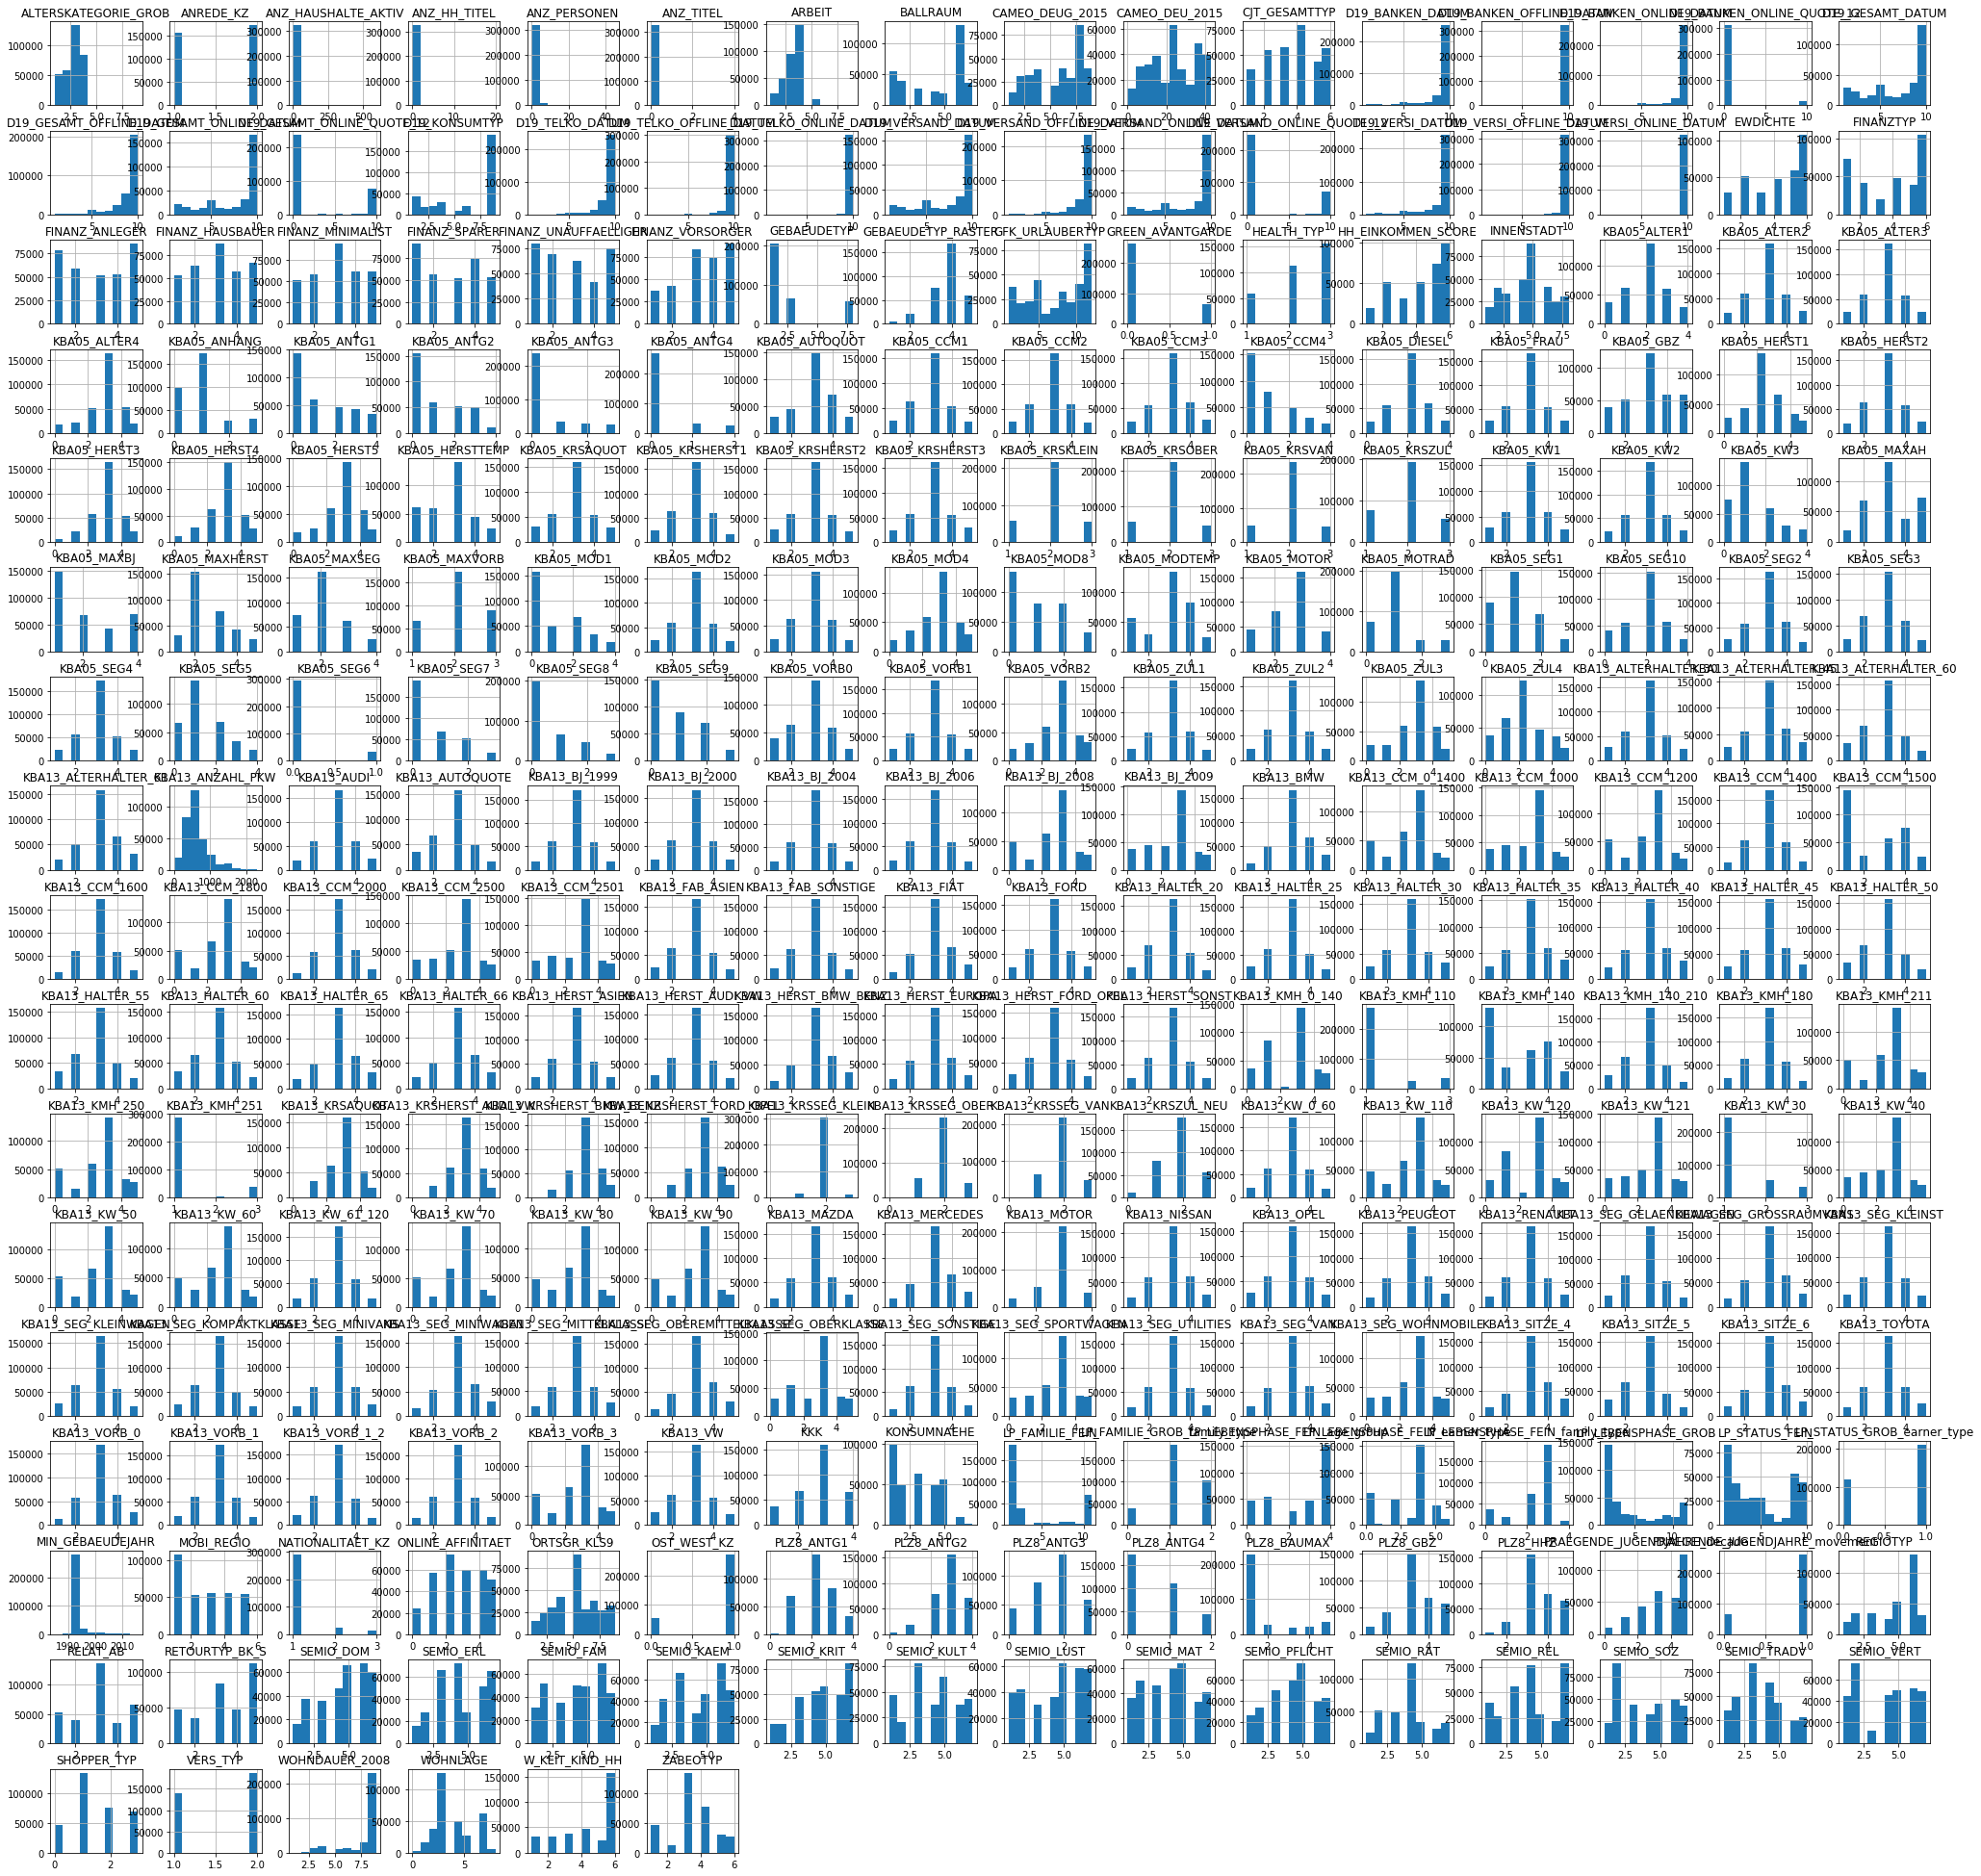

In [61]:
filtered_azdias.hist(figsize = (35,35))
plt.show()

In [74]:
def perform_log_transform(df):
    df_log = pd.DataFrame()

    for col in df.columns:
        df_log[col]=(df[col]+1).transform(np.log)
    return df_log

In [75]:
azdias_log = perform_log_transform(filtered_azdias)
customers_log = perform_log_transform(filtered_customers)


In [71]:
azdias_log.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_DATUM,...,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_LEBENSPHASE_FEIN_family_type,LP_LEBENSPHASE_FEIN_earner_type,LP_LEBENSPHASE_FEIN_age_group,LP_FAMILIE_GROB_family_type,LP_STATUS_GROB_earner_type,PRAEGENDE_JUGENDJAHRE_movement,PRAEGENDE_JUGENDJAHRE_decade
0,2.225776,0.0,0.693147,0.0,1.609438,1.945910,3.258097,2.197225,1.098612,2.397895,...,1.386294,0.693147,1.098612,0.000000,1.609438,0.693147,0.000000,0.693147,0.693147,1.791759
1,2.484907,0.0,1.098612,0.0,1.386294,1.945910,3.583519,2.197225,1.791759,2.397895,...,1.791759,1.098612,0.693147,1.609438,1.609438,1.609438,1.098612,0.693147,0.693147,1.791759
2,2.397895,0.0,0.693147,0.0,1.386294,1.098612,2.772589,1.609438,1.386294,2.397895,...,1.791759,1.098612,1.386294,1.386294,0.000000,1.609438,0.693147,0.693147,0.000000,1.791759
3,0.693147,0.0,0.000000,0.0,1.098612,1.609438,1.791759,1.098612,1.098612,2.397895,...,1.386294,1.098612,1.609438,1.386294,1.609438,1.609438,0.693147,0.000000,0.693147,1.386294
4,1.386294,0.0,1.609438,0.0,1.609438,1.098612,3.258097,1.945910,1.791759,1.791759,...,1.609438,0.693147,1.386294,1.098612,0.000000,0.693147,1.098612,0.693147,0.693147,1.386294


In [72]:
filtered_azdias.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_DATUM,...,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_LEBENSPHASE_FEIN_family_type,LP_LEBENSPHASE_FEIN_earner_type,LP_LEBENSPHASE_FEIN_age_group,LP_FAMILIE_GROB_family_type,LP_STATUS_GROB_earner_type,PRAEGENDE_JUGENDJAHRE_movement,PRAEGENDE_JUGENDJAHRE_decade
0,8.260665,0.0,1.0,0.0,4.0,6.0,25,8.0,2.0,10,...,3.0,1.0,2.0,0,4,1,0,1,1,5
1,11.000000,0.0,2.0,0.0,3.0,6.0,35,8.0,5.0,10,...,5.0,2.0,1.0,4,4,4,2,1,1,5
2,10.000000,0.0,1.0,0.0,3.0,2.0,15,4.0,3.0,10,...,5.0,2.0,3.0,3,0,4,1,1,0,5
3,1.000000,0.0,0.0,0.0,2.0,4.0,5,2.0,2.0,10,...,3.0,2.0,4.0,3,4,4,1,0,1,3
4,3.000000,0.0,4.0,0.0,4.0,2.0,25,6.0,5.0,5,...,4.0,1.0,3.0,2,0,1,2,1,1,3


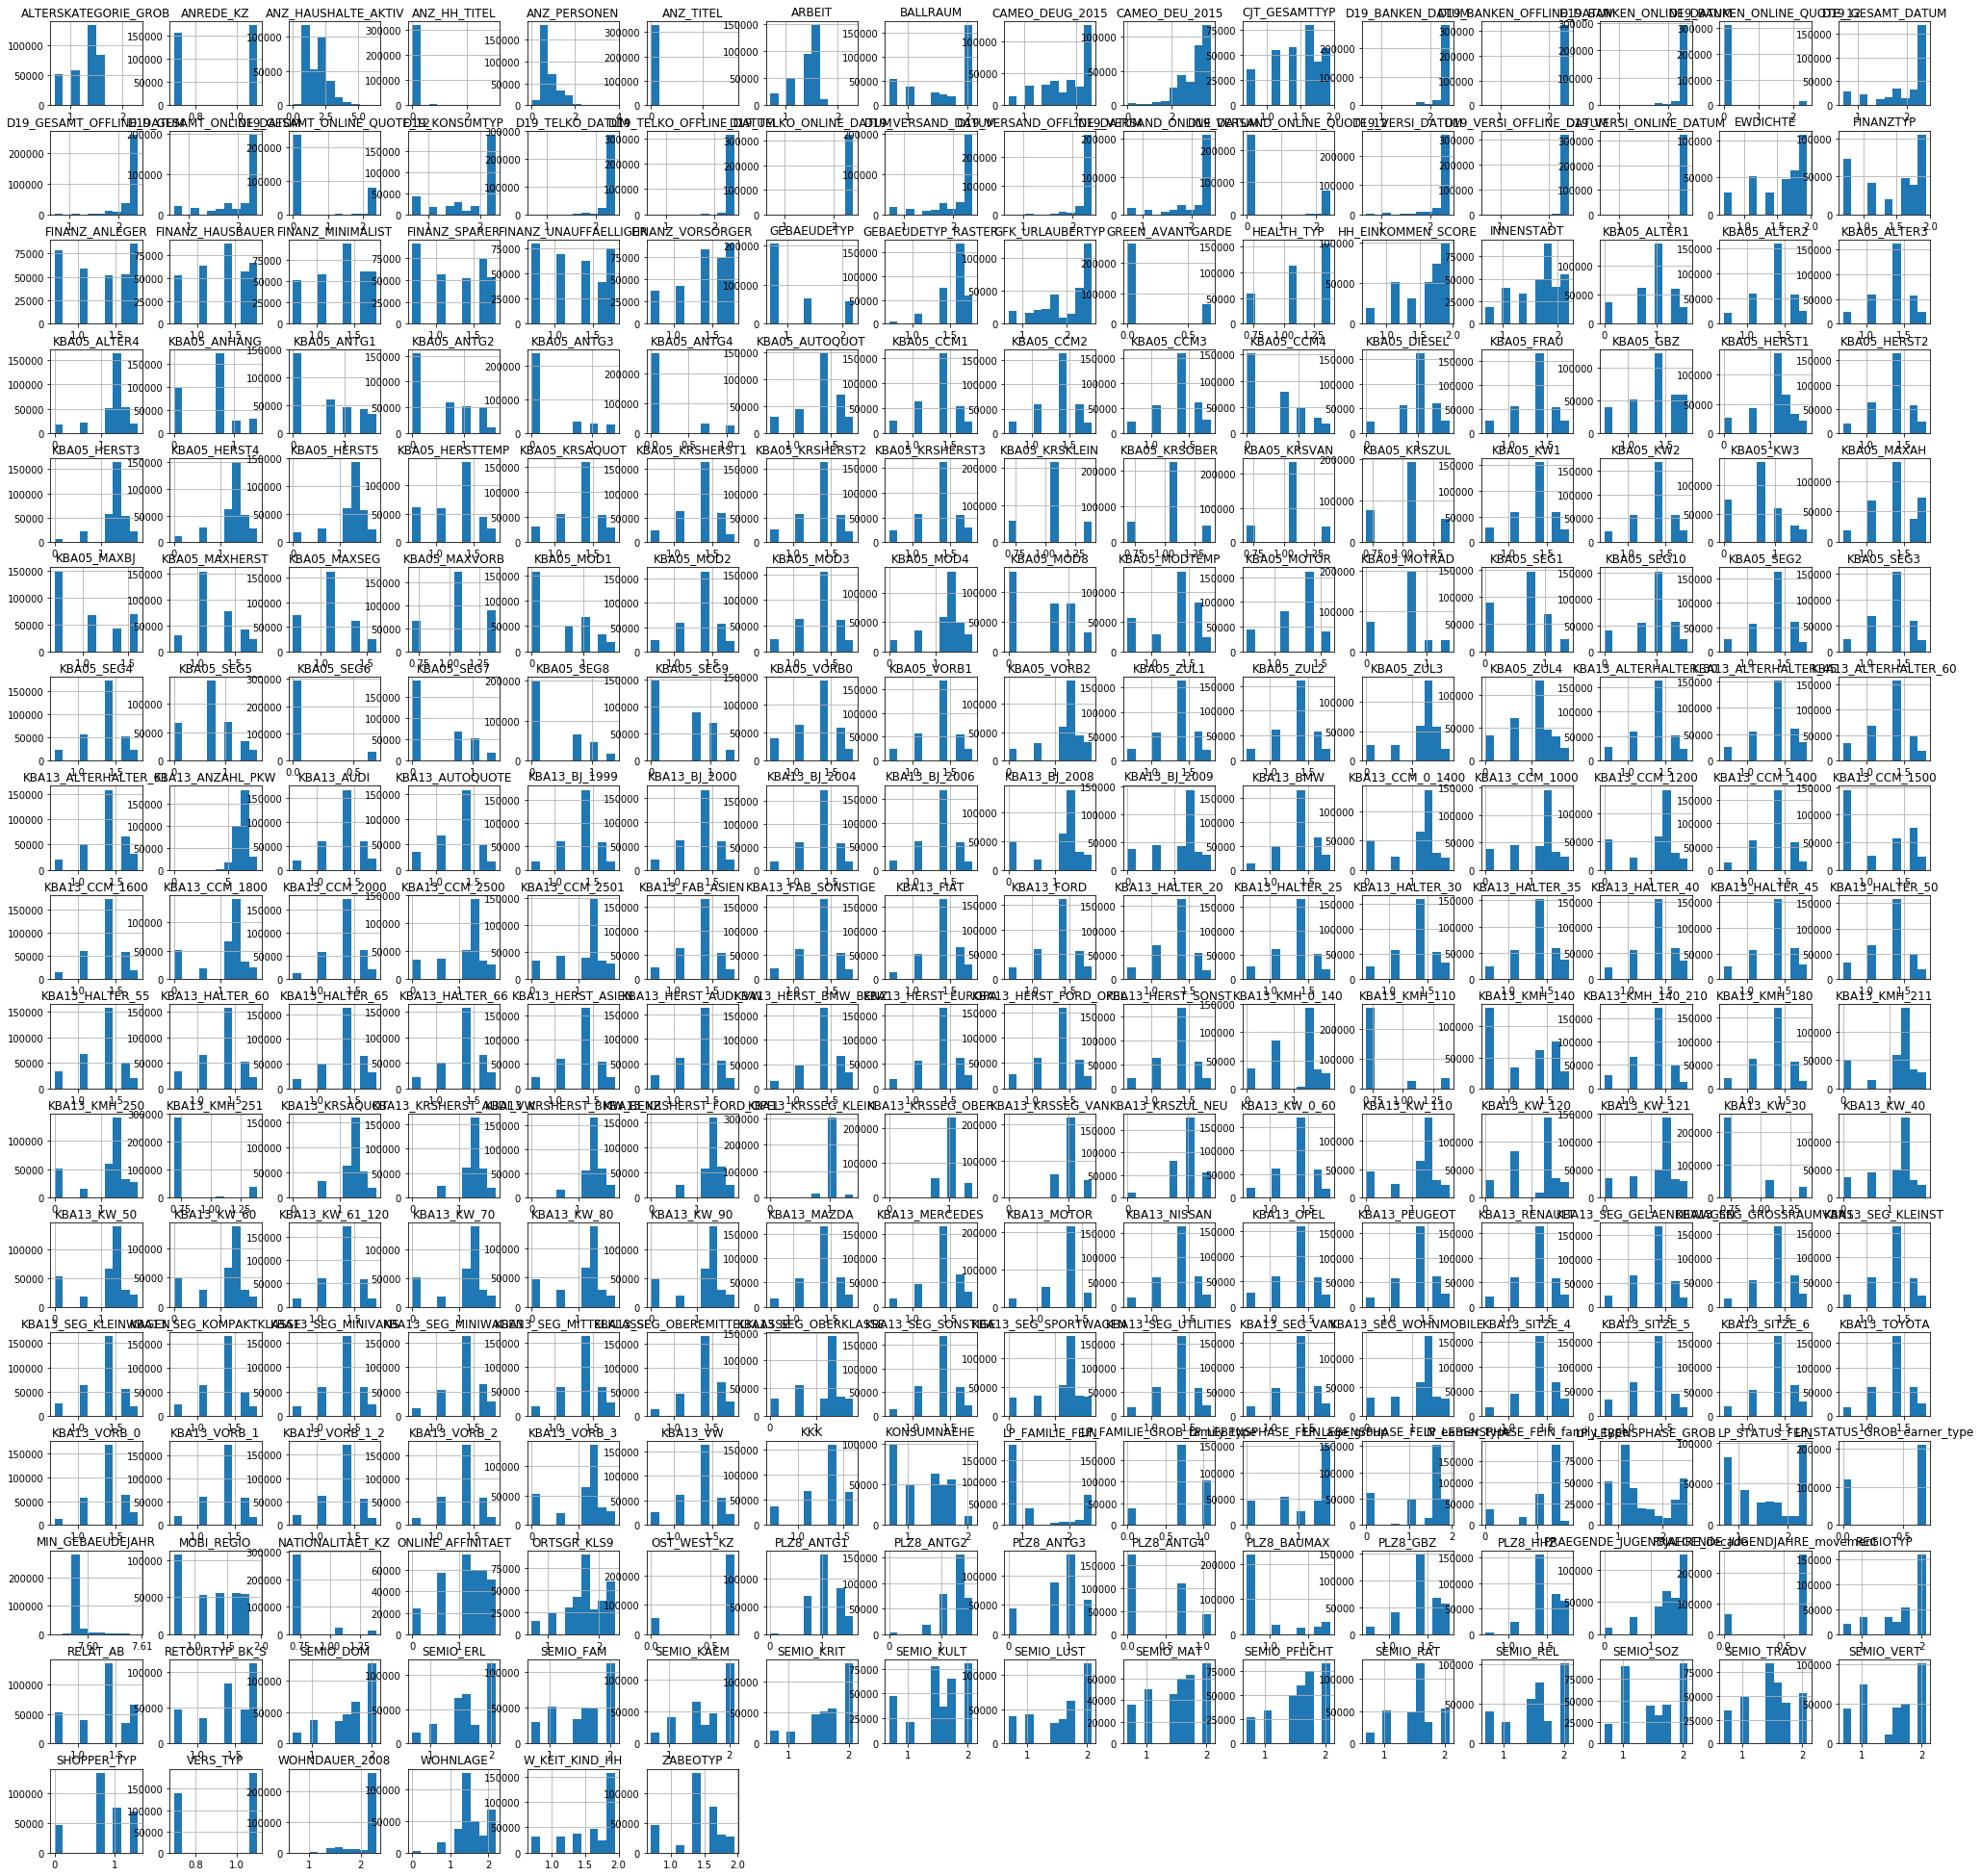

In [73]:
azdias_log.hist(figsize = (35,35))
plt.show()

In [57]:
def feature_scaling(df):
    
    scaled = MinMaxScaler().fit_transform(df.astype(float))

    return pd.DataFrame(scaled, columns = df.columns)
    

In [58]:
azdias_scaled = feature_scaling(filtered_azdias)
customers_scaled = feature_scaling(filtered_customers)

In [76]:
azdias_log_scaled = feature_scaling(azdias_log)
customers_log_scaled = feature_scaling(customers_log)

In [ ]:
customers_scaled.info()

In [ ]:
azdias_scaled.to_csv('./data/Udacity_AZDIAS_clean.csv', index=False, sep=';')
customers_scaled.to_csv('./data/Udacity_CUSTOMERS_clean.csv', index=False, sep=';')

In [ ]:
azdias_log_scaled.to_csv('./data/Udacity_AZDIAS_log_clean.csv', index=False, sep=';')
customers_log_scaled.to_csv('./data/Udacity_CUSTOMERS_log_clean.csv', index=False, sep=';')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [2]:
azdias = pd.read_csv('./data/Udacity_AZDIAS_clean.csv', sep=';')
customers = pd.read_csv('./data/Udacity_CUSTOMERS_clean.csv', sep=';')

In [ ]:
print(len(azdias.columns.values))
customers.info()

In [ ]:
# sagemaker libraries
import boto3
import sagemaker

In [ ]:
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

In [ ]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

In [ ]:
# define location to store model artifacts
prefix = 'arvato_pca'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

In [ ]:
N_COMPONENTS=261

In [ ]:
# define a PCA model
from sagemaker import PCA

# this is current features - 1
# you'll select only a portion of these to use, later

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)

In [ ]:
# convert df to np array
train_data_np = azdias.values.astype('float32')

In [ ]:


# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)

In [ ]:
%%time

# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

In [ ]:
# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console
training_job_name='pca-2020-10-08-12-36-22-792'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

In [ ]:
import mxnet as mx
#from sagemaker.mxnet import MXNet
# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

In [ ]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [ ]:
# looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  # 33-n

# print a selection of s
print(s.iloc[start_idx:, :])

In [ ]:
def plot_variance(s):
    
    exp_variance = list()
    for i in range(len(s)+1, 1, -1):
        exp_variance.append(np.square(s.iloc[i:,:]).sum()/np.square(s).sum())
    
    
    plt.plot(exp_variance)
    plt.xlabel('No of Components')
    plt.ylabel('Explained Variance')
    plt.title('Explained Variance Ratio')
    plt.grid(b=True)
    plot = plt.show()

In [ ]:
plot_variance(s)

In [ ]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)
    print(sorted_weight_data)
    
    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

In [ ]:
for i in range(1, 5):
    
    num=i
    display_component(v, azdias.columns.values, component_num=num, n_weights=10)

In [ ]:
%%time
# this takes a little while, around 7mins
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

In [ ]:
train_data_np[:10]

In [ ]:
split_arr = np.array_split(train_data_np[:30], 10)
for chunk in split_arr:
    print(chunk)


In [ ]:
train_pca = pca_predictor.predict(train_data_np[:30])

In [ ]:
# pass np train data to the PCA model
def predict_pca(data, rows=100):
    split_arr = np.array_split(data, rows)
    predictions = np.array([])
    
    for chunk in split_arr:
        predictions = np.append(predictions, pca_predictor.predict(chunk))
    return predictions

In [ ]:
train_pca = predict_pca(train_data_np)

In [ ]:
print(train_pca[0])

In [ ]:
# create dimensionality-reduced data
def create_transformed_df(train_pca, original_df, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param counties_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    pca_transformed=pd.DataFrame()

    t = time.time()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:

        # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        pca_transformed=pca_transformed.append([list(components)])
    print("Done in {:.2f} sec.".format(time.time()-t))


    # index by county, just like counties_scaled
    pca_transformed.index=original_df.index

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    pca_transformed = pca_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return pca_transformed.iloc[:, ::-1]

In [ ]:
# specify top n
top_n = 150

# call your function and create a new dataframe
pca_transformed = create_transformed_df(train_pca, azdias, n_top_components=top_n)

# add descriptive columns
#PCA_list=['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7']
#counties_transformed.columns=PCA_list 

# print result
pca_transformed.head()

In [ ]:
from sklearn.decomposition import PCA

def sklearn_pca(data, n_components):
    
    pca = PCA(n_components)
    pca.fit(data)
    data_transformed = pca.transform(data)
    return pca, data_transformed

In [ ]:
import time
from sklearn.cluster import KMeans

def plot_elbow_curve(data):
    
    points = np.array([])
    K = range(2,15)
    for k in K:
        
        t = time.time()
        
        kmeans = KMeans(k)
        km = kmeans.fit(data)
        points = np.append(points, np.abs(km.score(data)))
        print("Done in {:.2f} sec.".format(time.time()-t))
        
    plt.plot(K, points, 'bx-')
    plt.xlabel('no of K')
    plt.ylabel('avg distance to centroid')
    plt.title('Elbow Graph')
    plt.show()

In [ ]:
pca_azdias, pca_transformed = sklearn_pca(azdias, len(azdias.columns))

In [ ]:
plot_elbow_curve(pca_transformed)

In [ ]:
kmeans = KMeans(8)
km = kmeans.fit(pca_transformed)


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
zip -r project.zip .